In [1]:
import numpy as np
import scipy.stats.qmc as qmc

# Exericse sheet 7

## Exercise 2 (Two simple QMC test problems)

In [205]:
def generating_vectors_v2(N,s):
    
    def B_2(x):
        return np.power(x,2)-x + (1/6)
    
    U_N = np.gcd(np.arange(0,N), N)
    U_N = np.arange(N)[U_N==1]
    z = np.empty(s)
    p = np.ones(N)
    #print("U_N",U_N)
     
    G_N = B_2(np.modf(np.outer(U_N,np.arange(N))/N )[0])
    #print("G_N",G_N )
    #print("GN SHAPE",G_N.shape)
    #print("sum",np.sum(G_N,axis=0))
    #print("sum SHAPE",np.sum(G_N,axis=0).shape)
    z[0]=1
      
    for i in range(1,s):
        #print("p:",p)
        delta = (1/N)*np.inner(G_N,p )
        #print("delta",delta.shape)
        #print("argmin delta",np.argmin(delta))
        z[i]= U_N[np.argmin(delta)]
        p = np.multiply((np.ones(N) + G_N[i]),p)
    return z

generating_vectors_v2(64,2)

array([1., 1.])

In [204]:
def generating_vectors(s, N=None):
    # Source: https://wsc.project.cwi.nl/woudschoten-conferences/2016-woudschoten-conference/FKtalk1.pdf, Slide 14
    if s==2:
        return np.array([1, 19])
    if s==10:# Source: https://people.cs.kuleuven.be/~dirk.nuyens/qmc-generators/LATSEQ/exew_base2_m20_a3_HKKN.txt
        return np.array([1, 364981, 245389, 97823, 488939, 62609, 400749, 385317, 21281, 223487])
    else:
        return generating_vectors_v2(N,s)

In [3]:
def f(s: int, points: np.array) -> np.array:
    x = points.copy()
    C = (2 + 1 / (2 * s)) ** s

    x = x ** (1 + 1 / (2 * s))

    return C * np.prod(x, axis=1)

def g(s: int, points: np.array) -> np.array:
    x = points.copy()
    
    x = (x - 1 / 2) / np.arange(1, s + 1) ** 2
    
    return 1 + np.sum(x, axis=1)

In [4]:
def generate_lattice_points(
    z,  # generating vector
    m,  # 2 ** m number of points
    previous_lattice=np.array([]),  # reuse points from previous lattice
):
    def generate(index):
        return np.modf(
            np.reshape(index, (-1, 1)) * z / N
        )[0]

    # Set number of points.
    N = 2 ** m
    
    rows = np.arange(0, N, 1)

    if previous_lattice.size == 0:
        # Generate first lattice.
        new_lattice = generate(rows)
    else:
        new_lattice = np.empty([N, z.size])
        
        even_rows = rows[rows % 2 == 0]
        odd_rows = rows[rows % 2 == 1]
        
        new_lattice[even_rows] = previous_lattice
        new_lattice[odd_rows] = generate(odd_rows)
    
    return new_lattice

def shift_points(s: int, points: np.array):
    shift_vector = np.random.uniform(0, 1, s)
    
    return np.modf(points + shift_vector)[0]

In [5]:
def generate_sobol_points(
    s: int,
    m: int,
    scramble=True,
):
    sampler = qmc.Sobol(d=s, scramble=scramble)
    return sampler.random_base2(m=m)

In [111]:
def riemann_product_rule(
    fun, #chosen function
    N,  # number of intervals
    s,  # dimension
    trapez =False, #if trapzeoidal rule is used instead
):
    h = 1 / N  # interval size
    n = N + 1  # number of points
    
    points = np.meshgrid(*[np.linspace(0, 1, n) for _ in range(s)])
    points = np.array(points).T.reshape(-1, s)
     
    weights = np.full( np.full(s,N+1), h ** s)
    
    if trapez:
        for i in range(s):
            np.swapaxes(weights,0,i)[0] /=2
            np.swapaxes(weights,0,i)[-1] /=2
    weights = weights.flatten()
    

    return np.sum( fun(s, points) * weights)

In [ ]:
s = 10
z = generating_vectors(s)
m = 10

In [16]:
points = generate_lattice_points(z, m)
np.mean(f(s, points))

0.9996513237528162

In [12]:
points = generate_sobol_points(s, m, scramble=False)
np.mean(f(s, points))

1.0396389683923086

In [112]:
print(riemann_product_rule(f,50, 4,trapez=False))

print(riemann_product_rule(f,50, 4,trapez=True))

1.0879442561108281
1.0001842944696069


### Part (a)

Compute the error for different $N$ and $s$ and compare the results for the product rules from Exercise Sheet 1.

### Part (b)

USING DIFFERENT Rs:

In [121]:
R = [8, 16, 32]

In [122]:
m=10
N_samples = 1000

In [123]:
points = generate_lattice_points(z, m)
i=0
lattice_est = np.empty(len(R))
lattice_sample_var = np.empty(len(R))
z = generating_vectors(s)
points = generate_lattice_points(z, m)

for N_samples in R:
    lattice_estimates = []
    for _ in range(N_samples):
        shifted_points = shift_points(s, points)
        lattice_estimates.append(
            np.mean(g(s, shifted_points))
        )
        
    lattice_est[i] = np.mean(np.array(lattice_estimates))
    lattice_sample_var[i]  = np.var(lattice_estimates,ddof=1)
    i+=1
print(lattice_sample_var)

[1.21933704e-07 6.41598687e-08 7.49462214e-08]


In [124]:
latice_error = np.abs(1 - lattice_est)
latice_error


array([7.21465393e-05, 2.61178938e-05, 9.93011046e-05])

In [141]:

i=0
sobol_est = np.empty(len(R))
sobol_sample_var = np.empty(len(R)) 
for N_samples in R:
    sobol_estimates = []
    for _ in range(N_samples):
        scrambled_points = generate_sobol_points(s, m, scramble=True)
        sobol_estimates.append(
            np.mean(g(s, scrambled_points))
        )
        
    sobol_est[i] = np.mean(np.array(sobol_estimates))
    
    sobol_sample_var[i] = np.var(sobol_estimates,ddof=1)
    i+=1
print(sobol_sample_var)

[1.11022302e-16 3.38813179e-21 1.77635684e-15]


In [142]:
sobol_error = np.abs(1 - sobol_est)
sobol_error


array([3.14321369e-09, 5.96628524e-10, 6.86850399e-09])

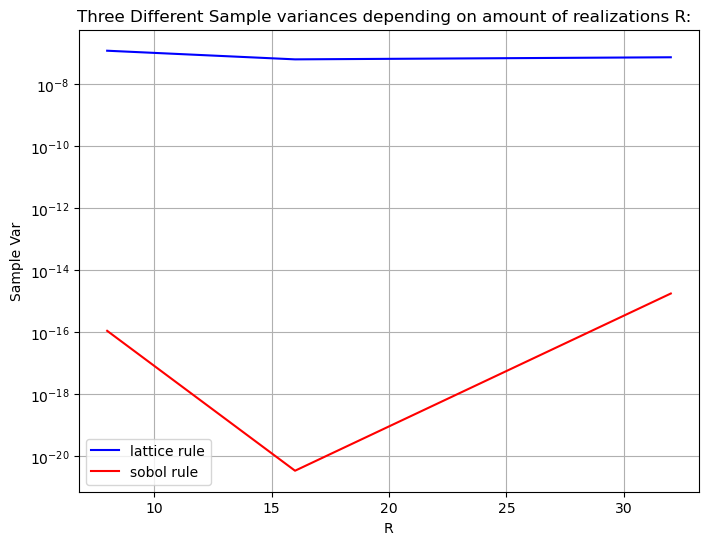

In [143]:
import matplotlib.pyplot as plt
 

 
 
# Plot the curves
plt.figure(figsize=(8, 6))
plt.plot(R, lattice_sample_var, label="lattice rule", color='blue')
plt.plot(R,sobol_sample_var, label="sobol rule", color='red')
#plt.plot(R, y3, label="tan(x)", color='green')



# Adding labels and title
plt.xlabel("R")
plt.ylabel("Sample Var")
plt.title("Three Different Sample variances depending on amount of realizations R:  ")

# Show legend
plt.legend()

# Display the plot
plt.yscale("log")
plt.grid(True)
plt.show()


USING DIFFERENT NUMBERS OF POINTS, ALSO COMPARING IT WITH MC:

In [115]:
def MC_integrate(
    fun, #chosen function
    N,  # number of points
    s,  # dimension
     
):
    xs = np.random.uniform(0,1,(N,s))
    return  fun(s, xs)

In [ ]:
s=10
R=32

mmesh = np.arange(10,21)
print(mmesh)
sobol_est = np.empty(len(mmesh))
sobol_sample_var = np.empty(len(mmesh)) 
lattice_est = np.empty(len(mmesh))
lattice_sample_var = np.empty(len(mmesh)) 

MC_est = np.empty(len(mmesh)) 
MC_sample_var =  np.empty(len(mmesh)) 
i=0
for m in mmesh:
    
    z = generating_vectors(s)
    points = generate_lattice_points(z, m)

    MCs=   MC_integrate(g, 2**m*R,s)
    MC_est[i] = np.mean(MCs)
    MC_sample_var[i] =  np.var(MCs,ddof=1)
    
    
    sobol_estimates = []
    lattice_estimates = []
    for _ in range(R):
        scrambled_points = generate_sobol_points(s, int(m), scramble=True)
        sobol_estimates.append(
            np.mean(g(s, scrambled_points))
        )
        shifted_points = shift_points(s, points)
        lattice_estimates.append(
            np.mean(g(s, shifted_points))
        )
        
    sobol_est[i] = np.mean(np.array(sobol_estimates))
    sobol_sample_var[i] = np.var(sobol_estimates,ddof=1)
    lattice_est[i] = np.mean(np.array(lattice_estimates))
    lattice_sample_var[i] = np.var(lattice_estimates,ddof=1)
    i+=1
print(sobol_sample_var)
print(lattice_sample_var)
print(MC_est)
print(MC_sample_var)

[10 11 12 13 14 15 16 17 18 19 20]
[5.20014520e-14 8.50432463e-12 4.73497866e-17 1.07355063e-32
 7.10542736e-15 1.94829558e-32 5.64608108e-32 1.74948991e-32
 5.56655881e-33 9.42338884e-32 1.94829558e-32]
[8.92682504e-08 9.73321649e-08 8.97213939e-08 8.74922421e-08
 9.33803370e-08 1.10324462e-07 5.85632655e-08 1.05237005e-07
 1.02419842e-07 1.16855306e-07 8.47051143e-08]
[0.99924399 1.00067689 0.99805051 1.00005737 0.99967701 1.00013773
 1.00009321 1.00022504 0.99985314 1.000048   0.99999016]
[0.08958007 0.08978178 0.08998511 0.09016992 0.08986143 0.09017887
 0.09012418 0.09020326 0.09018512 0.09016346 0.0901705 ]


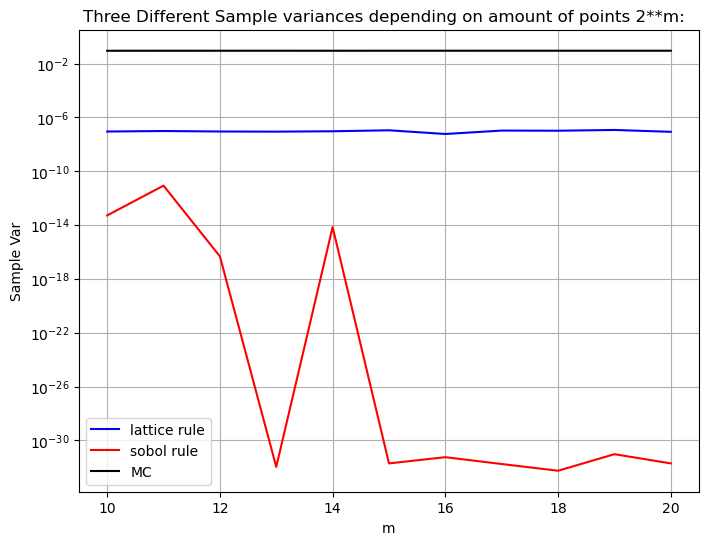

In [ ]:
import matplotlib.pyplot as plt
 

 
 
# Plot the curves
plt.figure(figsize=(8, 6))
plt.plot(mmesh, lattice_sample_var, label="lattice rule", color='blue')
plt.plot(mmesh,sobol_sample_var, label="sobol rule", color='red')
plt.plot(mmesh,MC_sample_var, label="MC", color='black')
#plt.plot(R, y3, label="tan(x)", color='green')



# Adding labels and title
plt.xlabel("m")
plt.ylabel("Sample Var")
plt.title("(s=10) Three Different Sample variances depending on amount of points 2**m:  ")

# Show legend
plt.legend()

# Display the plot
plt.yscale("log")
plt.grid(True)
plt.show()


COMPARING LOW VS HIGH DIMENSIONALITY, (FIXED AMOUNT OF POINTS)

In [207]:
smesh= np.arange(2,10)
R=32
m=10
 

sobol_est = np.empty(len(smesh))
sobol_sample_var = np.empty(len(smesh)) 
lattice_est = np.empty(len(smesh))
lattice_sample_var = np.empty(len(smesh)) 

MC_est = np.empty(len(smesh)) 
MC_sample_var =  np.empty(len(smesh)) 
i=0
for s in smesh:
    #generate new points for lattice rule
    z = generating_vectors(s,2**m)
    points = generate_lattice_points(z, m)

    MCs=   MC_integrate(g, 2**m*R,s)
    MC_est[i] = np.mean(MCs)
    MC_sample_var[i] =  np.var(MCs,ddof=1)
    
    
    sobol_estimates = []
    lattice_estimates = []
    for _ in range(R):
        scrambled_points = generate_sobol_points(s, int(m), scramble=True)
        sobol_estimates.append(
            np.mean(g(s, scrambled_points))
        )
        shifted_points = shift_points(s, points)
        lattice_estimates.append(
            np.mean(g(s, shifted_points))
        )
        
    sobol_est[i] = np.mean(np.array(sobol_estimates))
    sobol_sample_var[i] = np.var(sobol_estimates,ddof=1)
    lattice_est[i] = np.mean(np.array(lattice_estimates))
    lattice_sample_var[i] = np.var(lattice_estimates,ddof=1)
    i+=1
print(sobol_sample_var)
print(lattice_sample_var)
print(MC_sample_var)

[1.86264515e-09 1.98805672e-33 2.12757388e-12 1.86304048e-09
 1.86264507e-09 1.17958449e-10 1.81516429e-18 2.91503044e-11]
[7.22388554e-08 7.39547635e-08 9.14355713e-08 6.74891229e-08
 9.21797233e-08 8.73113436e-08 5.07458500e-08 7.61903377e-08]
[0.08919408 0.08941684 0.09013465 0.09003096 0.09056535 0.08939441
 0.08991001 0.09050992]


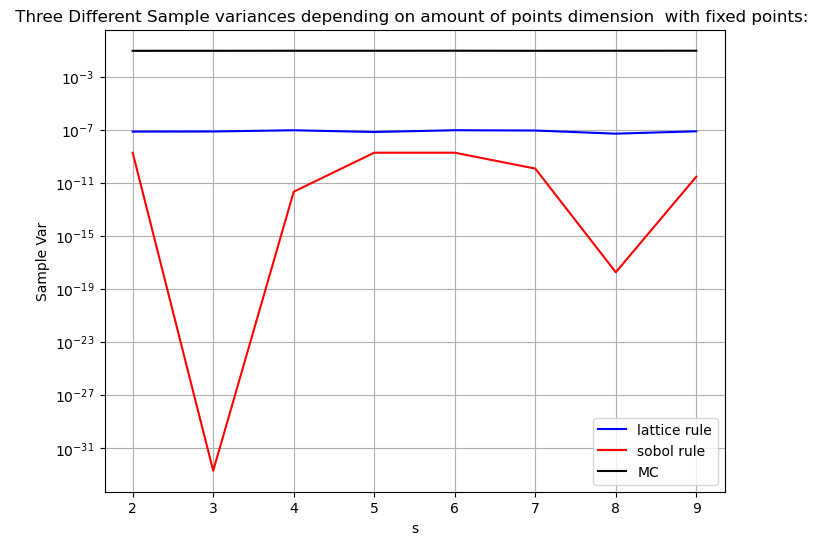

In [208]:
import matplotlib.pyplot as plt
 

 
 
# Plot the curves
plt.figure(figsize=(8, 6))
plt.plot(smesh, lattice_sample_var, label="lattice rule", color='blue')
plt.plot(smesh,sobol_sample_var, label="sobol rule", color='red')
plt.plot(smesh,MC_sample_var, label="MC", color='black')
#plt.plot(R, y3, label="tan(x)", color='green')



# Adding labels and title
plt.xlabel("s")
plt.ylabel("Sample Var")
plt.title(" Three Different Sample variances depending on amount of points dimension  with fixed points:  ")

# Show legend
plt.legend()

# Display the plot
plt.yscale("log")
plt.grid(True)
plt.show()
